# Fine Tuning BERT for Disaster Tweets Classification

Text classification is a technique for putting text into different categories and has a wide range of applications: email providers use text classification to detect to spam emails, marketing agencies use it for sentiment analysis of customer reviews, and moderators of discussion forums use it to detect inappropriate comments.

In the past, data scientists used methods such as tf-idf, word2vec, or bag-of-words (BOW) to generate features for training classification models. While these techniques have been very successful in many NLP tasks, they don't always capture the meanings of words accurately when they appear in different contexts. Recently, we see increasing interest in using Bidirectional Encoder Representations from Transformers (BERT) to achieve better results in text classification tasks, due to its ability more accurately encode the meaning of words in different contexts.

BERT was trained on BookCorpus and English Wikipedia data, which contain 800 million words and 2,500 million words, respectively. Training BERT from scratch would be prohibitively expensive. By taking advantage of transfer learning, one can quickly fine tune BERT for another use case with a relatively small amount of training data to achieve state-of-the-art results for common NLP tasks, such as text classification and question answering.

Amazon SageMaker is a fully managed service that provides developers and data scientists with the ability to build, train, and deploy machine learning (ML) models quickly. Amazon SageMaker removes the heavy lifting from each step of the machine learning process to make it easier to develop high-quality models. The SageMaker Python SDK provides open source APIs and containers that make it easy to train and deploy models in Amazon SageMaker with several different machine learning and deep learning frameworks.

In this example, we walk through our dataset, the training process, and finally model deployment.

In [1]:
#! poetry add transformers 

## Environment setup

In [2]:

import os
import numpy as np
import pandas as pd
# import sagemaker

# sagemaker_session = sagemaker.Session()    # Provides a collection of methods for working with SageMaker resources

# bucket = "aws-sagemaker-nlp-2021"
# prefix = "sagemaker/DEMO-pytorch-bert"

# role = sagemaker.get_execution_role()      # Get the execution role for the notebook instance. 
#                                            # This is the IAM role that we created for our notebook instance. 
#                                            # We pass the role to the tuning job(later on).

## Prepare data
- get sentences
- get lables

In [3]:
df = pd.read_csv("../dataset/raw/data.csv", header=None, usecols=[1, 3], names=["label", "sentence"],)
sentences = df.sentence.values
labels = df.label.values
df.tail()

,label,sentence
7608,1,Two giant cranes holding a bridge collapse int...
7609,1,@aria_ahrary @TheTawniest The out of control w...
7610,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611,1,Police investigating after an e-bike collided ...
7612,1,The Latest: More Homes Razed by Northern Calif...


In [4]:
# print few tweets with its class label
list(zip(sentences[80:85], labels[80:85]))

[("mom: 'we didn't get home as fast as we wished' \nme: 'why is that?'\nmom: 'there was an accident and some truck spilt mayonnaise all over ??????",
  0),
 ("I was in a horrible car accident this past Sunday. I'm finally able to get around. Thank you GOD??",
  1),
 ('Can wait to see how pissed Donnie is when I tell him I was in ANOTHER accident??',
  0),
 ("#TruckCrash Overturns On #FortWorth Interstate http://t.co/Rs22LJ4qFp Click here if you've been in a crash&gt;http://t.co/Ld0unIYw4k",
  1),
 ('Accident in #Ashville on US 23 SB before SR 752 #traffic http://t.co/hylMo0WgFI',
  1)]

### Clean  data

In [5]:
import string
import re

# Helper functions to clean text by removing urls, emojis, html tags and punctuations.

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [6]:
df['sentence'] = df['sentence'].apply(lambda x: remove_URL(x))
df['sentence'] = df['sentence'].apply(lambda x: remove_emoji(x))
df['sentence'] = df['sentence'].apply(lambda x: remove_html(x))
df['sentence'] = df['sentence'].apply(lambda x: remove_punct(x))

df.head()

,label,sentence
0,1,Our Deeds are the Reason of this earthquake Ma...
1,1,Forest fire near La Ronge Sask Canada
2,1,All residents asked to shelter in place are be...
3,1,13000 people receive wildfires evacuation orde...
4,1,Just got sent this photo from Ruby Alaska as s...


In [7]:
sentences = df.sentence.values
labels = df.label.values

## Data EDA

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df['label'].value_counts()

label
0    4342
1    3271
Name: count, dtype: int64

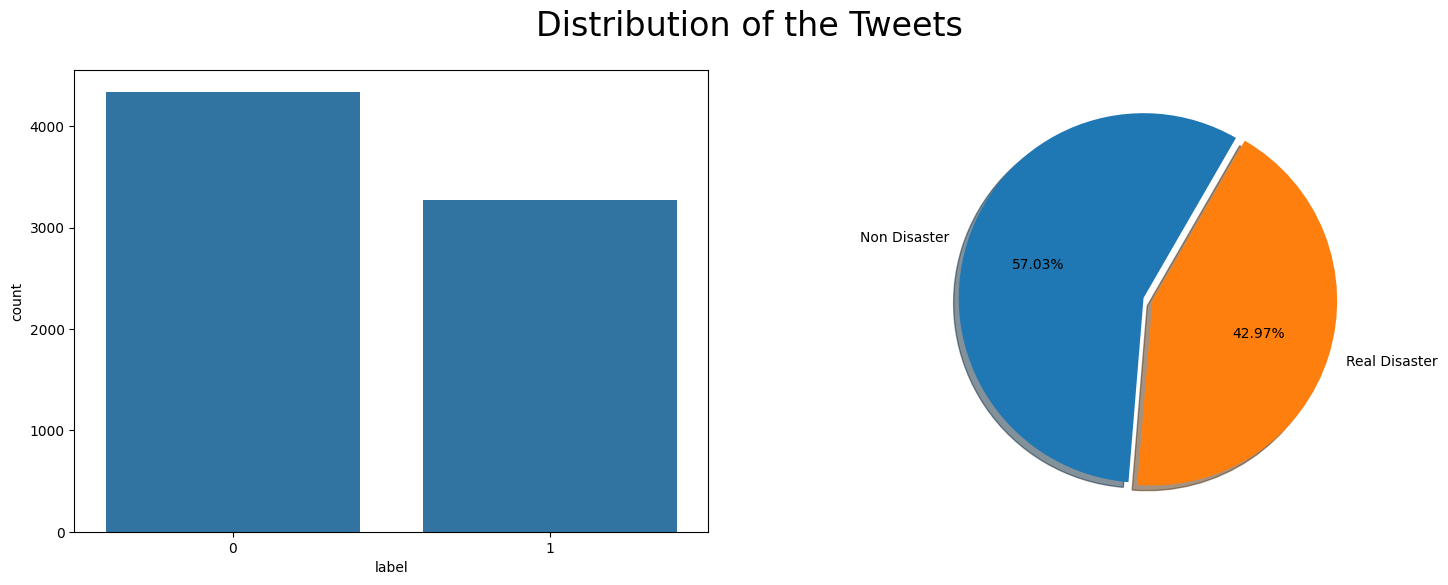

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(x='label', data=df, ax=axes[0])
axes[1].pie(df['label'].value_counts(),
            labels=['Non Disaster', 'Real Disaster'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

/Users/tianyuliu/Code/llm/NLP_examples/src/nlp_basic/Bert/Bert_for_Text_Classfication/src/util.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[:, feature],
/Users/tianyuliu/Code/llm/NLP_examples/src/nlp_basic/Bert/Bert_for_Text_Classfication/src/util.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5

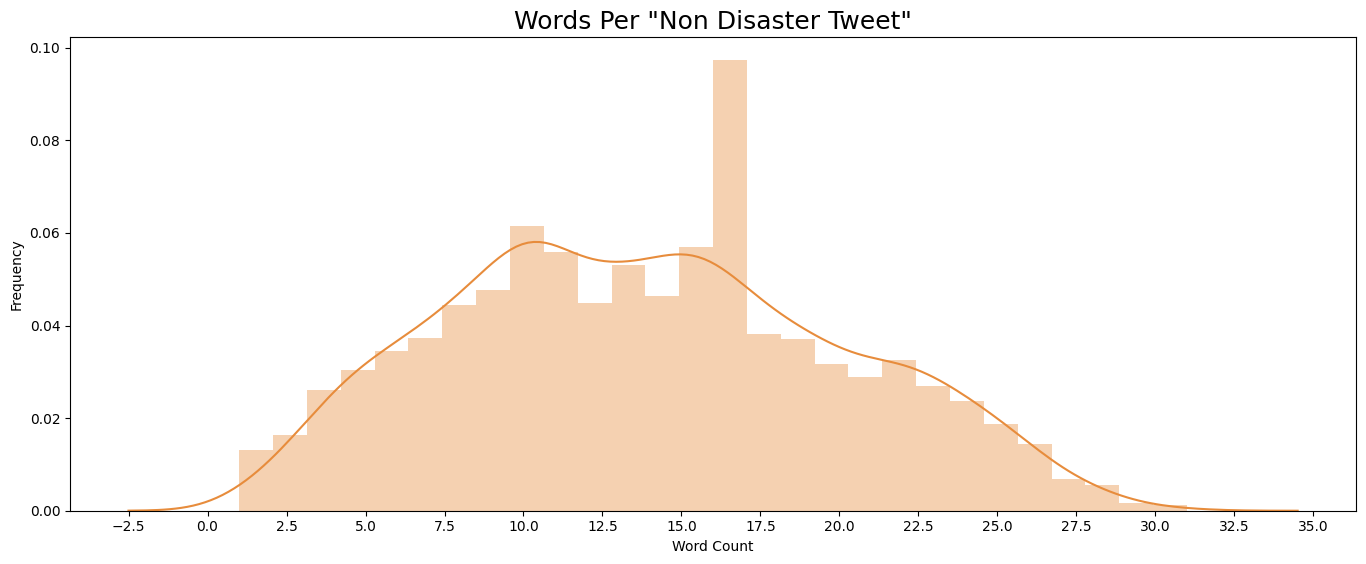

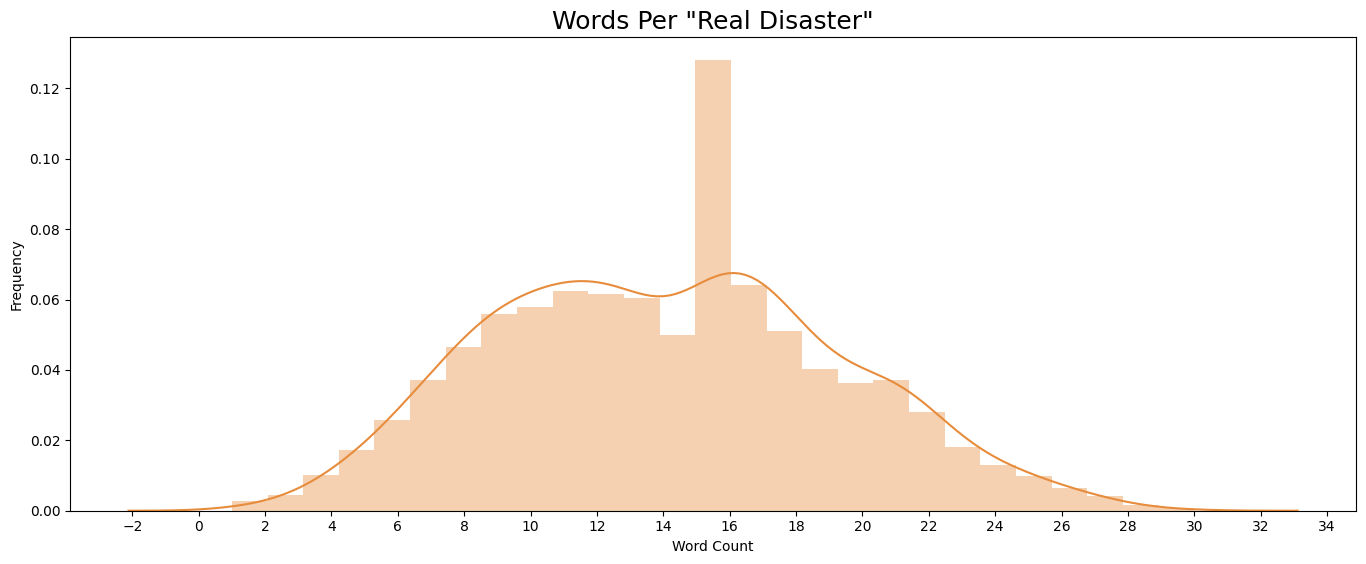

In [11]:
import util
df['Word Count'] = df['sentence'].apply(lambda x: len(str(x).split()))
util.plot_dist_char(df[df['label'] == 0], 'Word Count', 'Words Per "Non Disaster Tweet"')
util.plot_dist_char(df[df['label'] == 1], 'Word Count', 'Words Per "Real Disaster"')

### Split the dataset for training and testing


In [12]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df)               # Default split ratio 75/25, we can modify using "test_size"
train.to_csv("../dataset/train.csv", index=False)
test.to_csv("../dataset/test.csv", index=False)

## Training script - train_deploy.py

In [13]:
#  pring the train_deploy.py script
!pygmentize train_deploy.py

# For training the model 

import argparse
import json
import logging
import os
import sys

import numpy as np
import pandas as pd
import torch
import torch.distributed as dist
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data import DataLoader, RandomSampler, TensorDataset, WeightedRandomSampler
from transformers import AdamW, BertForSequenceClassification, BertTokenizer, get_linear_schedule_with_warmup


logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

MAX_LEN = 64  # this is the max length of the sentence


print("Loading BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)



def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)



def _get_train_data_loader(batch_size, training_dir, is_distributed):
  

In [14]:
import argparse
import torch
from train_deploy import train  # Ensure train_deploy.py has a callable train function

# Set up the arguments manually as would be done in SageMaker's PyTorch estimator.
args = argparse.Namespace(
    num_labels=2,
    batch_size=64,
    test_batch_size=64,
    epochs=2,
    lr=5e-5,
    momentum=0.5,
    seed=1,
    log_interval=50,
    # backend="gloo",  # Modify as needed for your setup
    model_dir="../model/",
    training_data_dir="../dataset/",
    testing_data_dir="../dataset/",
    num_gpus=torch.cuda.device_count()
)

# # Initialize distributed training if needed
# if args.backend in ("gloo", "nccl"):
#     torch.distributed.init_process_group(backend=args.backend)

# Run the training function with these arguments
train(args)

/Users/tianyuliu/Library/Caches/pypoetry/virtualenvs/nlp-examples-2S-piTS9-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BERT tokenizer...
Distributed training - False
Number of gpus available - 0
Get train data loader


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/tianyuliu/Library/Caches/pypoetry/virtualenvs/nlp-examples-2S-piTS9-py3.12/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/Users/tianyuliu/Library/Cac

Processes 5709/5709 (100%) of train data
Processes 1904/1904 (100%) of test data
Starting BertForSequenceClassification



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


End of defining BertForSequenceClassification



/Users/tianyuliu/Library/Caches/pypoetry/virtualenvs/nlp-examples-2S-piTS9-py3.12/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Train Epoch: 1 [0/5709 (0%)] Loss: 0.657840
Train Epoch: 1 [3200/5709 (56%)] Loss: 0.690192
Average training loss: 0.675047

Test set: Accuracy: 0.666667

Train Epoch: 2 [0/5709 (0%)] Loss: 0.698442
Train Epoch: 2 [3200/5709 (56%)] Loss: 0.697026
Average training loss: 0.670527

Test set: Accuracy: 0.625000

Saving tuned model.
